# Assignment 3 Clustering Algorithms
### Evaluating DBSCAN, k-Means & Hierarchical Clustering



In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import GridSearchCV


In [ ]:
# Function to plot clustering results; 
from sklearn.metrics import silhouette_samples

# Define function to take inputs and handle different clustering methods
# This function will plot the clustering results and silhouette scores for the given data and labels.
# It will also handle the case where cluster centers are provided (e.g., for KMeans) or not (e.g., for DBSCAN or Agglomerative Clustering).
def plot_clustering_results(X, labels, centers, silhouette_avg, n_clusters=4, method_name='KMeans'):
    """
    Plots the clustering results and the silhouette scores for each sample.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data points.
    labels : array-like, shape (n_samples,)
        The cluster labels for each data point.
    centers : array-like, shape (n_clusters, n_features), optional
        The coordinates of the cluster centers. If None, no centers are plotted.
    silhouette_avg : float
        The average silhouette score for all the samples.
    n_clusters : int, optional, default=4
        The number of clusters.
    method_name: str
        The name of the clustering method used (e.g., 'KMeans', 'Agglomerative', etc.).    

    Returns:
    None
    """
    
    unique_labels = np.unique(labels) # Get unique cluster labels
    cluster_labels = unique_labels[unique_labels != -1] # Exclude noise label (-1) if present
    n_clusters = len(cluster_labels) # Count the number of clusters excluding noise
    has_noise = -1 in unique_labels # Check if noise is present in the labels
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7)) # Create a figure with two subplots
    
    # --- Left Plot: Clustering Result ---
    scatter = ax1.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis') 
    if centers is not None:
        ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids') # Plot cluster centers if provided; this is for kMeans
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    title = f"{method_name} Clustering with {n_clusters} Cluster{'s' if n_clusters != 1 else ''}" # Set the title of the plot; take method_name input
    if has_noise:
        title += " (+ Noise)" # If noise is present, append it to the title
    ax1.set_title(title)

    # --- Right Plot: Silhouette Plot ---
    mask = labels != -1 # Create a mask to exclude noise points from the silhouette plot
    if n_clusters >= 2: # Ensure there are at least two clusters for silhouette analysis
        if silhouette_avg is None: # If silhouette_avg is None, calculate it
            silhouette_avg = np.mean(silhouette_samples(X[mask], labels[mask])) # Calculate the average silhouette score for the samples excluding noise
        sample_silhouette_values = silhouette_samples(X[mask], labels[mask]) # Calculate silhouette values for each sample excluding noise; when average silhouette score is provided

        y_lower = 10 # Initialize the lower y-coordinate for the silhouette plot
        for i, label in enumerate(cluster_labels): # Iterate through each cluster label
            ith_cluster_silhouette_values = sample_silhouette_values[labels[mask] == label] 
            ith_cluster_silhouette_values.sort() # Sorts the silhouette values for the current cluster

            size_cluster_i = ith_cluster_silhouette_values.shape[0] # Get the size of the current cluster
            y_upper = y_lower + size_cluster_i # Calculates the upper y-coordinate for the current cluster

            color = plt.cm.nipy_spectral(float(i) / n_clusters) # Get a color for the current cluster based on its index
            ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, # Fill the silhouette plot for the current cluster
                              facecolor=color, edgecolor=color, alpha=0.7) 

            ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label)) # Add the cluster label to the silhouette plot
            y_lower = y_upper + 10 # Sets the lower coordinate for the next cluster

        ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax2.set_title(f"Silhouette Plot for {method_name} Clustering")
        ax2.set_xlabel("Silhouette Coefficient Values")
        ax2.set_ylabel("Cluster Label")
        ax2.set_yticks([])
        ax2.set_xticks(np.arange(-0.1, 1.1, 0.2))
    else:
        ax2.set_title(f"Silhouette Plot Unavailable for {method_name}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()
    

In [ ]:
#Generate synthetic datasets
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=[1.0, 2.5, 0.5], random_state=42)
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)

## Evaluating Clustering Models on the Moons Dataset

The moons dataset has non-spherical clusters. DBSCAN is predicted to perform well on this dataset, while k-Means may struggle.

c:\Users\simra\.pixi\envs\default\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.49


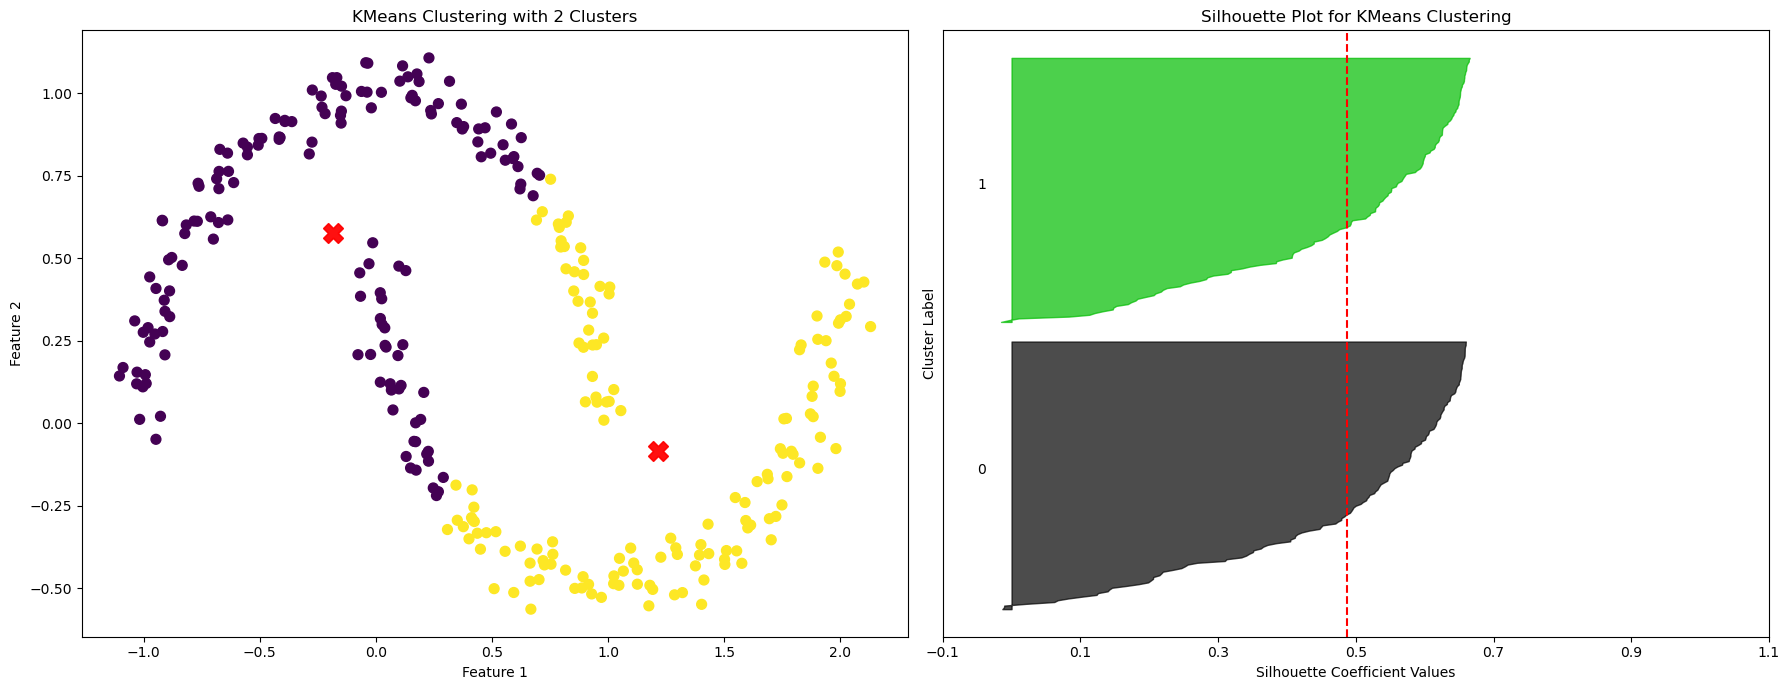

In [66]:
# Clustering with KMeans on Moons Dataset

kmeans_moons = KMeans(n_clusters=2, max_iter=3, init='random', random_state=42)
kmeans_moons.fit(X_moons)
y_kmeans_moons = kmeans_moons.predict(X_moons)

# Evaluate the model
silhouette_kmeans_moons = silhouette_score(X_moons, y_kmeans_moons)
print(f"Silhouette Score: {silhouette_kmeans_moons:.2f}")

# Plot the clustering results using the defined function
centers = kmeans_moons.cluster_centers_
plot_clustering_results(X_moons, y_kmeans_moons, centers, silhouette_kmeans_moons, n_clusters=4, method_name='KMeans')

Silhouette Score (Agglomerative): 0.48


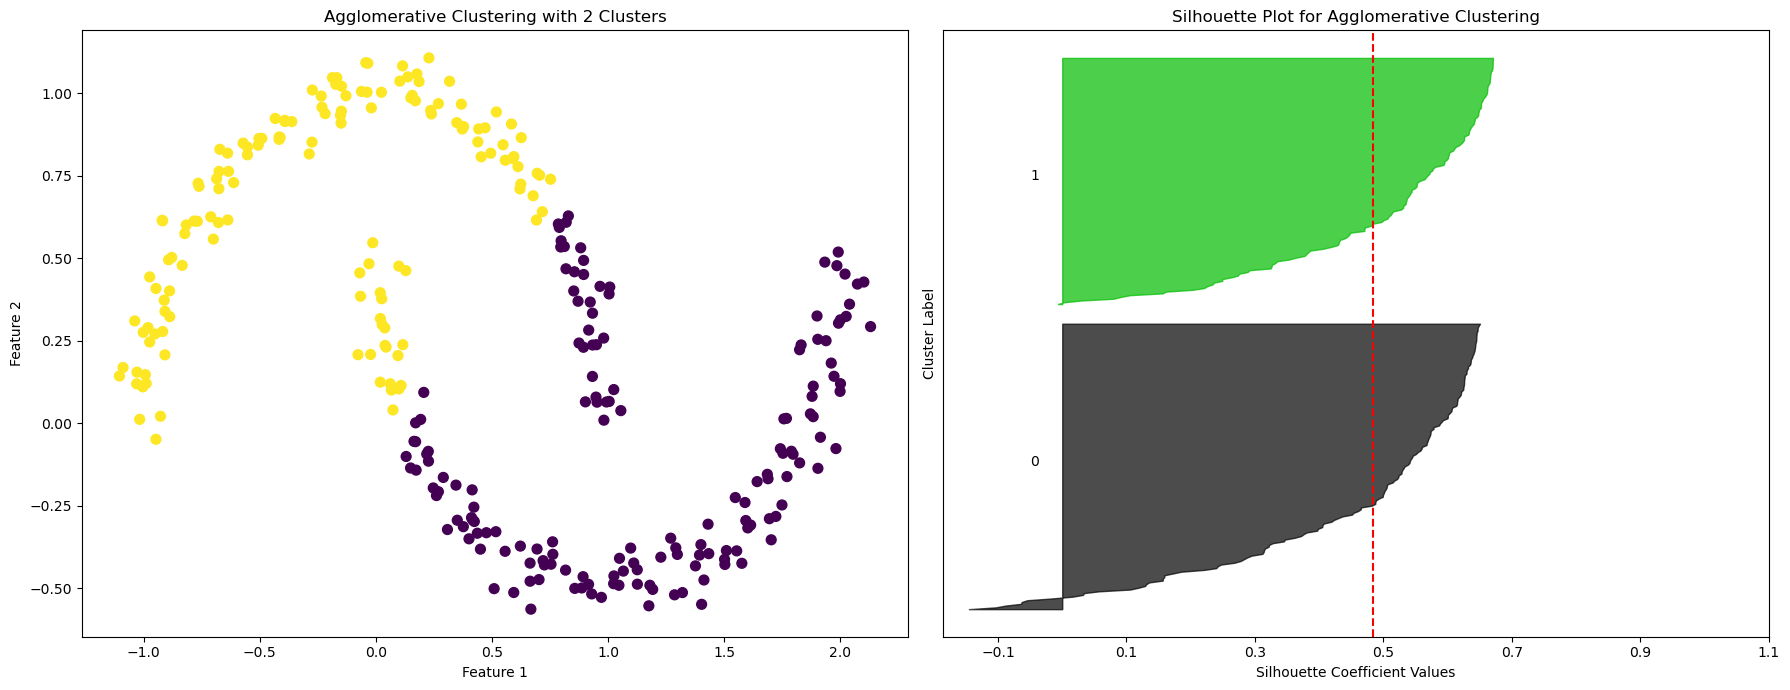

In [67]:
# Clustering with Hierarchical Clustering on Moons Dataset


# Train the agglomerative clustering model
agglo_moons = AgglomerativeClustering(n_clusters=2, linkage ='complete', metric = 'manhattan')
y_agglo_moons = agglo_moons.fit_predict(X_moons)

# Evaluate the model
silhouette_agglo_moons = silhouette_score(X_moons, y_agglo_moons)
print(f"Silhouette Score (Agglomerative): {silhouette_agglo_moons:.2f}")

# Plot the clustering results using the defined function
plot_clustering_results(X_moons, y_agglo_moons, None, silhouette_agglo_moons, n_clusters=4, method_name='Agglomerative')

Silhouette Score (DBSCAN): 0.39


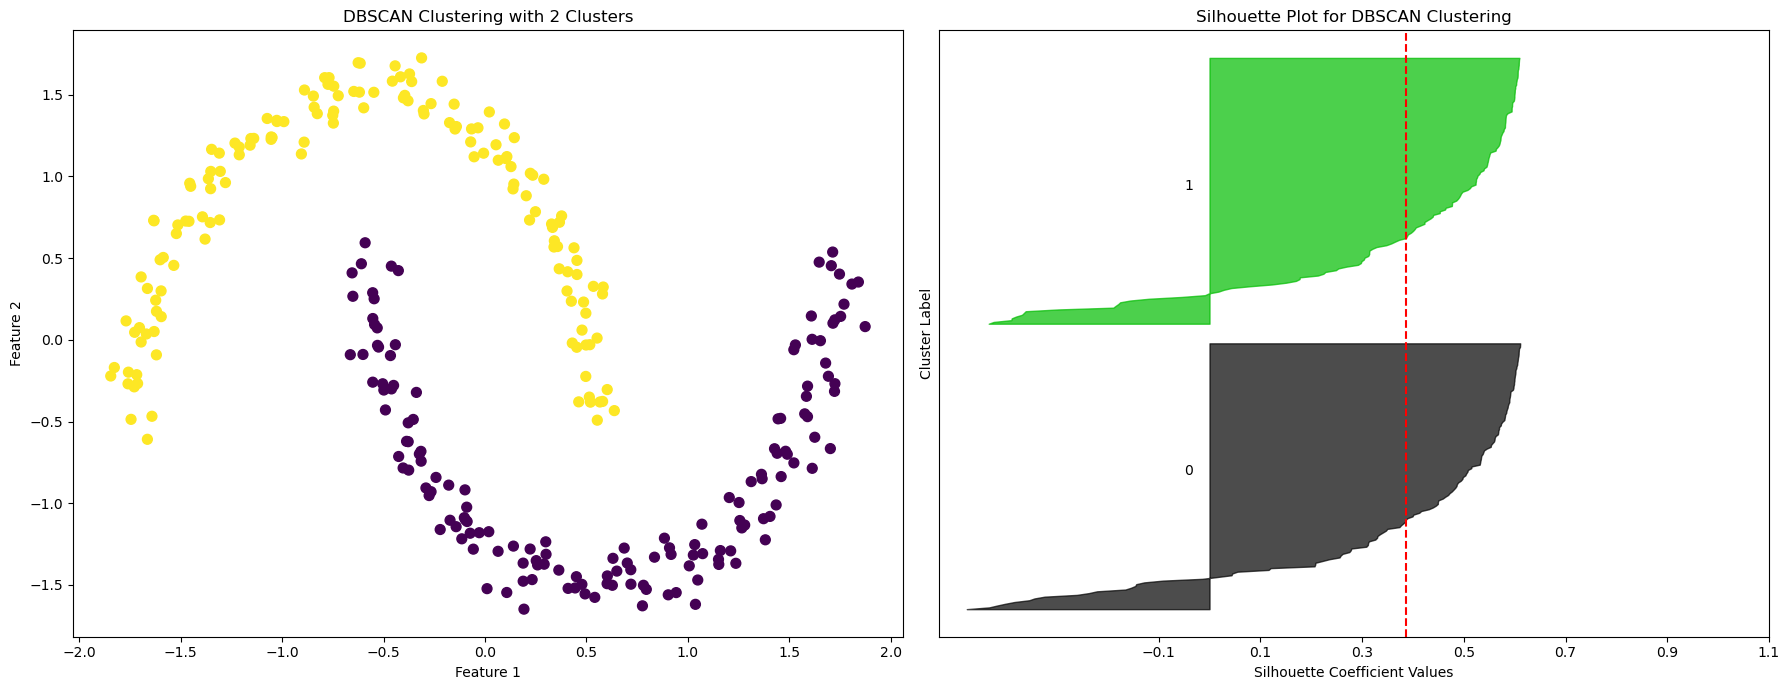

In [68]:
# Clustering with DBSCAN on the Moons Dataset

from sklearn.preprocessing import StandardScaler

# Standardize features (important for DBSCAN)
X_moons_scaled = StandardScaler().fit_transform(X_moons)

# Train DBSCAN clustering on the blobs dataset
db_moons = DBSCAN(eps=0.5, min_samples=5) #Try different eps & min_samples values
y_db_moons = db_moons.fit_predict(X_moons_scaled)

# Filter noise for internal metrics
X_moons_scaled_filtered = X_moons_scaled[y_db_moons != -1]

# Evaluate the model
silhouette_db_moons = silhouette_score(X_moons_scaled, y_db_moons) if len(set(y_db_moons)) > 1 else -1
print(f"Silhouette Score (DBSCAN): {silhouette_db_moons:.2f}")

# Plot the clustering results using the defined function
plot_clustering_results(X_moons_scaled, y_db_moons, None, silhouette_db_moons, n_clusters=len(set(y_db_moons)) - (1 if -1 in y_db_moons else 0), method_name = 'DBSCAN')

## Evaluating Clustering Models on the Blobs Dataset

The blobs dataset has clusters with varying densities and some outliers. It is likely that DBSCAN may struggle with these densities.

c:\Users\simra\.pixi\envs\default\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score: 0.69


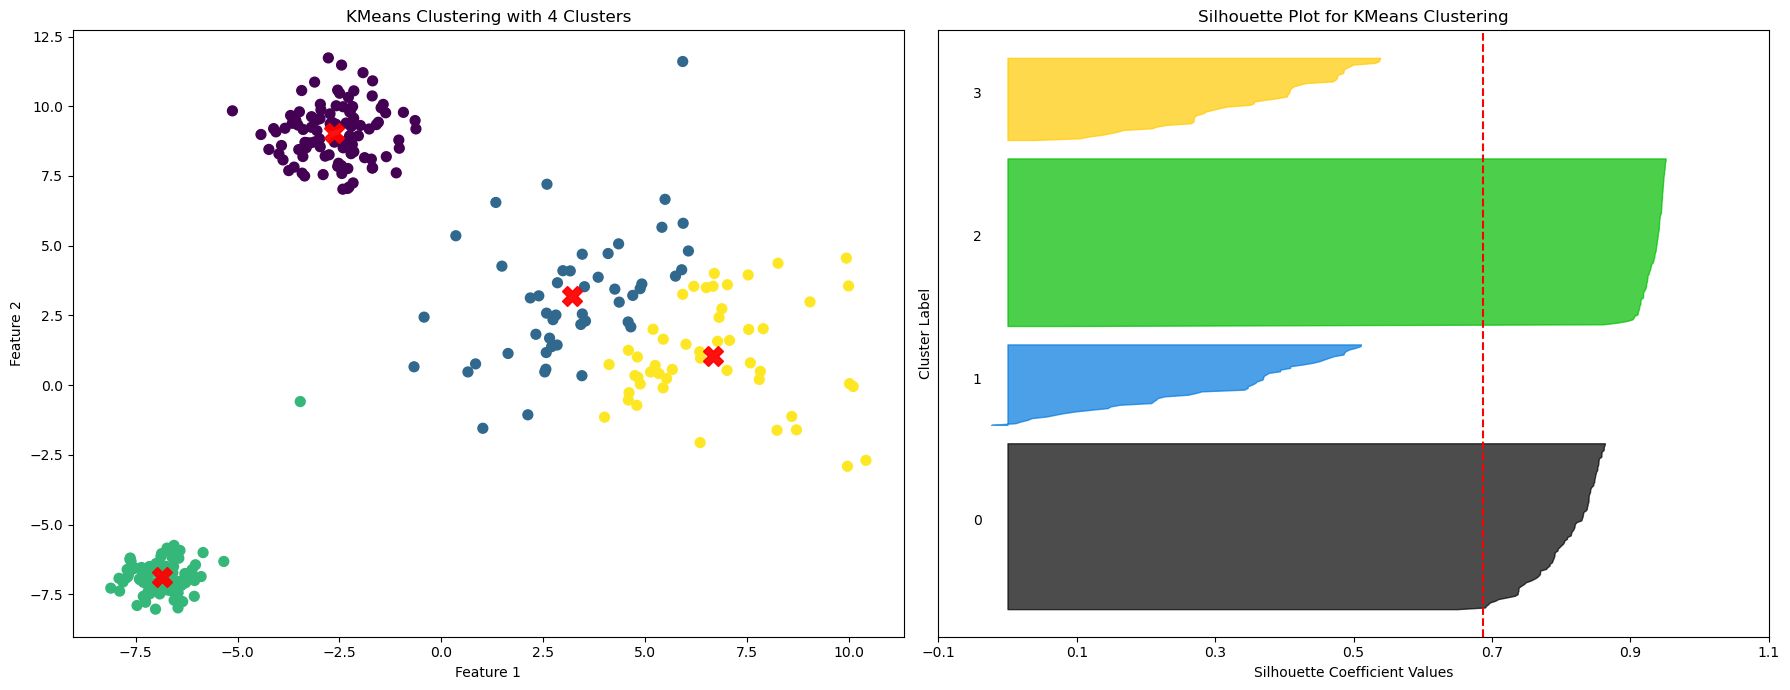

In [69]:
# Train KMeans clustering on the blobs dataset

kmeans_blobs = KMeans(n_clusters=4, max_iter=10, init='random', random_state=42)
kmeans_blobs.fit(X_blobs)
y_kmeans_blobs = kmeans_blobs.predict(X_blobs)

# Evaluate the model
silhouette_kmeans_blobs = silhouette_score(X_blobs, y_kmeans_blobs)
print(f"Silhouette Score: {silhouette_kmeans_blobs:.2f}")

# Plot the clustering results using the defined function
centers = kmeans_blobs.cluster_centers_
plot_clustering_results(X_blobs, y_kmeans_blobs, centers, silhouette_kmeans_blobs, n_clusters=4, method_name = 'KMeans')

Silhouette Score (Agglomerative): 0.67


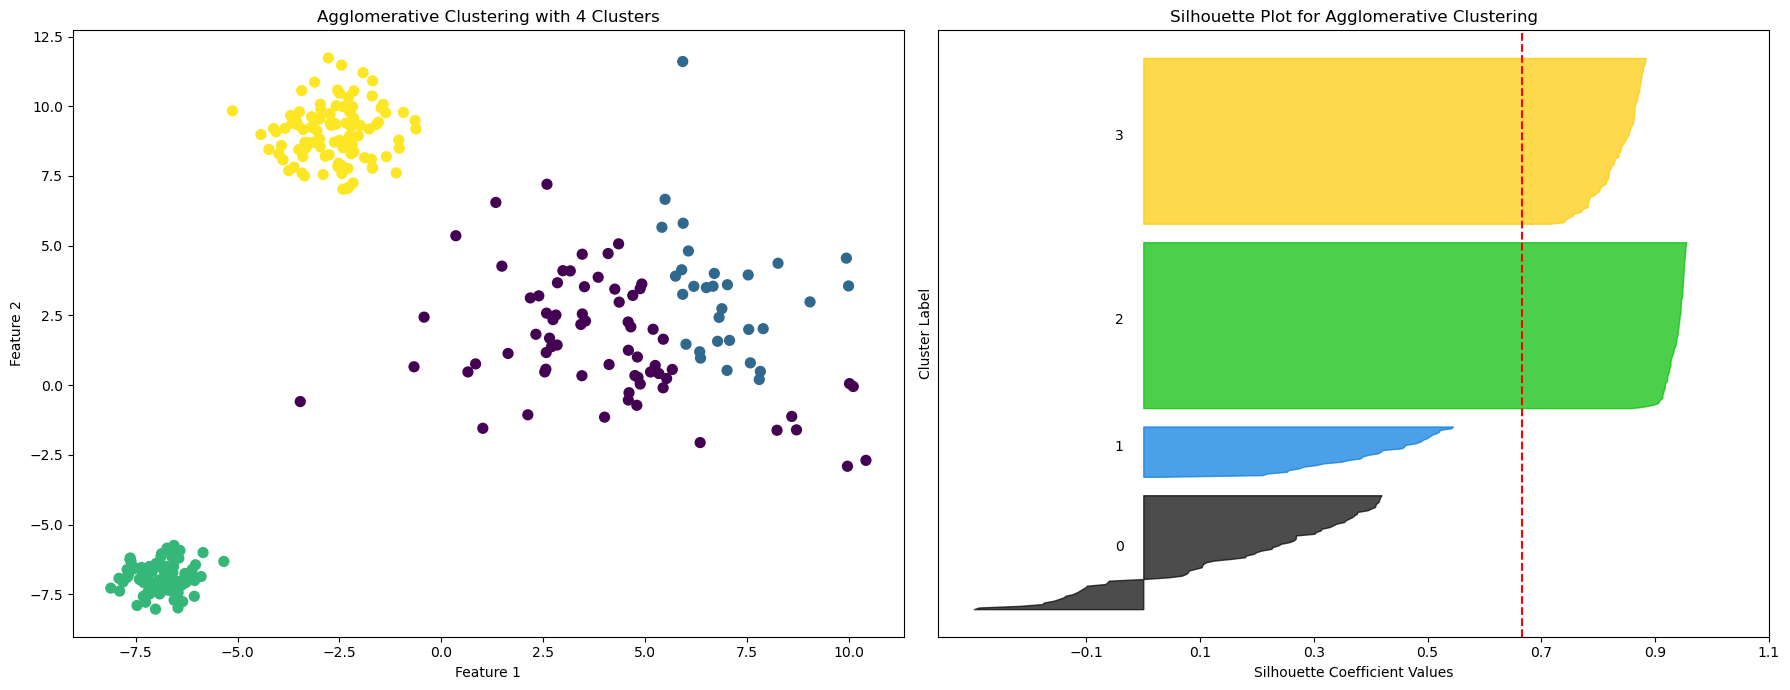

In [70]:
# Hierarchical

# Train the agglomerative clustering model
agglo_blobs = AgglomerativeClustering(n_clusters=4, linkage ='complete', metric = 'manhattan')
y_agglo_blobs = agglo_blobs.fit_predict(X_blobs)

# Evaluate the model
silhouette_agglo_blobs = silhouette_score(X_blobs, y_agglo_blobs)
print(f"Silhouette Score (Agglomerative): {silhouette_agglo_blobs:.2f}")

# Plot the clustering results using the defined function
plot_clustering_results(X_blobs, y_agglo_blobs, None, silhouette_agglo_blobs, n_clusters=4, method_name = 'Agglomerative')

Silhouette Score (DBSCAN): 0.48


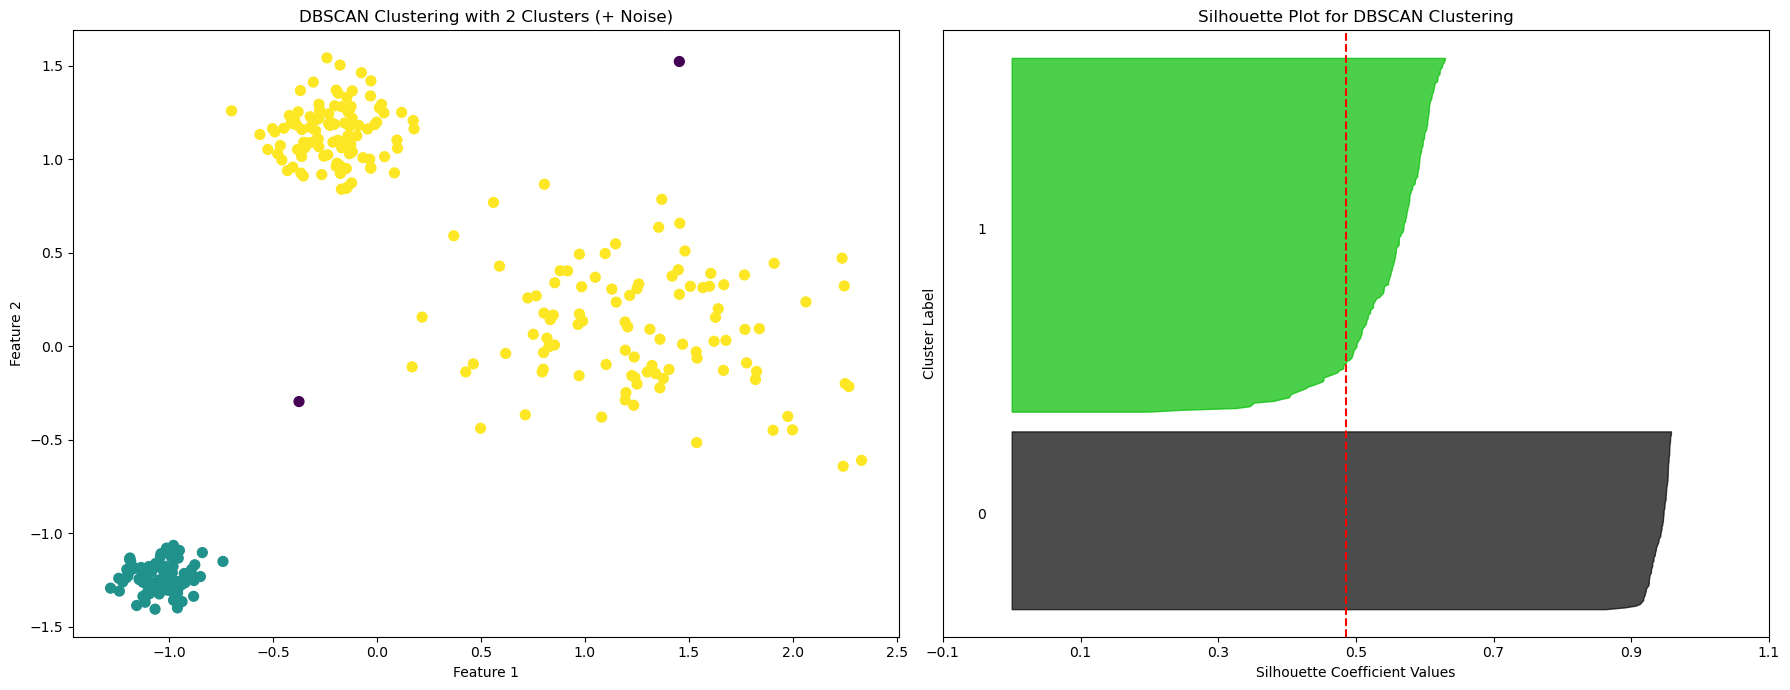

In [71]:

# DBSCAN

# Standardize features (important for DBSCAN)
X_blobs_scaled = StandardScaler().fit_transform(X_blobs)

# Train DBSCAN clustering on the blobs dataset
db_blobs = DBSCAN(eps=0.5, min_samples=5) #Try different eps & min_samples values
y_db_blobs = db_blobs.fit_predict(X_blobs_scaled)

# Filter noise for internal metrics
X_blobs_scaled_filtered = X_blobs_scaled[y_db_blobs != -1]

# Evaluate the model
silhouette_db_blobs = silhouette_score(X_blobs_scaled, y_db_blobs) if len(set(y_db_blobs)) > 1 else -1
print(f"Silhouette Score (DBSCAN): {silhouette_db_blobs:.2f}")

# Plot the clustering results using the defined function
plot_clustering_results(X_blobs_scaled, y_db_blobs, None, silhouette_db_blobs, n_clusters=len(set(y_db_blobs)) - (1 if -1 in y_db_blobs else 0), method_name = 'DBSCAN')
